# Borders, Obstacles & Buffering

**OptiWindNet** models site bounds with an exterior **border** (build area) and interior **obstacles** (exclusions), and keeps electrical network design compliant with the bounds. This notebook walks from initialization and optimization under constraints, through cleaning and buffering the geometry, to validating turbine/substation placement. We will explore following features (methods):

* **Optimize under bounds**: `.optimize()`: optimize electrical network while enforcing border/obstacle constraints.
* **Merge & clean boundary**: `.merge_obstacles_into_border()`: resolve intersections/touching constriants, absorb irrelevant obstacles, and simplify the exterior boundary.
* **Buffer geometry**: `.buffer_border_obstacles(buffer_dist=...)`: expand the border and shrink obstacles to add safety margins; might smooth concavities or remove obstacles depending on `buffer_dist`.
* **Compare originals vs buffered**: `.plot_original_vs_buffered()`: overlay plot of border/obstacles before and after buffering to inspect how buffering changed shapes.
* **Validate placement**: `.is_layout_within_bounds()`: confirm turbines/substations lie inside the border and outside obstacles.

Import required packages

In [119]:
from optiwindnet.api import WindFarmNetwork
import numpy as np
import matplotlib.pyplot as plt

In [120]:
# Display figures as SVG in Jupyter notebooks
%config InlineBackend.figure_formats = ['svg']

## Borders and obstacles

### 1. Initialize
Create a `WindFarmNetwork` instances from an `osm.pbf´ file and optimize it.

In [121]:
wfn1 = WindFarmNetwork.from_pbf(filepath='data/DTU_letters.osm.pbf', cables=7)
res_optimize = wfn1.optimize()

Plot the location graph and the optimized network to confirm that the borders and obstacles are properly initailized and concidered for optimization.

<Axes: >

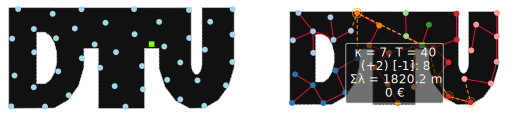

In [122]:
fig, axs = plt.subplots(1, 2, facecolor='none', figsize=(9, 4))
ax1, ax2= axs.flatten()
wfn1.plot_location(ax=ax1)
wfn1.plot(ax=ax2)

> Note: OptiWindNet works properly without borders/obstacles also.

### 2. Obstacles intersecting with the exterior borders

Let's create an instance of WindFarmNetwork directly via coordinates to have full control over border/obstacle definition.

<Axes: >

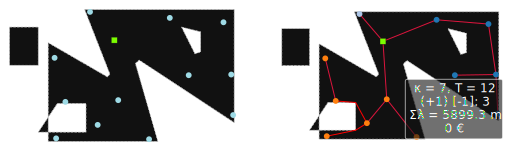

In [123]:
borderC = np.array(
    [[1951, 200], [1951, 1383], [386, 1383], [650, 708], [624, 678],
     [4, 1036], [4, 3], [1152, 3], [917, 819], [957, 854]],
    dtype=float)
obstaclesC = [
    np.array([[1540, 920], [1600, 940], [1600, 1150], [1400, 1200]]),
    np.array([[-400, 800], [-100, 800], [-100, 1200], [-400, 1200]]),
    np.array([[-100, 100], [400, 100], [400, 400], [100, 400]]),
]

substationsC = np.array([[696, 1063],], dtype=float)
turbinesC = np.array(
    [[1940, 279], [1920, 703], [1475, 696], [1839, 1250],
     [1277, 1296], [442, 1359], [737, 435], [1060, 26],
     [522, 176], [87, 35], [184, 417], [71, 878]],
    dtype=float
)

wfn2 = WindFarmNetwork(turbinesC=turbinesC, substationsC=substationsC, cables=7, borderC=borderC, obstaclesC=obstaclesC)
res_optimize = wfn2.optimize()
fig, axs = plt.subplots(1, 2, facecolor='none', figsize=(9, 4))
ax1, ax2= axs.flatten()
wfn2.plot_location(ax=ax1)
wfn2.plot(ax=ax2)

We can use `.merge_obstacles_into_border()` to refine the borders and simplify the layout and remove unrelavant obstacles.

Obstacle at index 1 is completely outside the border and is neglected.
Obstacle at index 2 intersects with the exteriour border and is merged into the exterior border.


<Axes: >

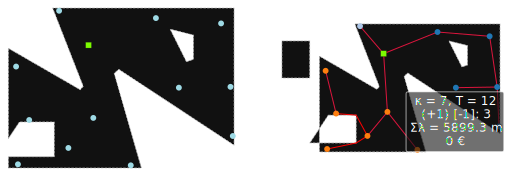

In [124]:
wfn2.merge_obstacles_into_border()
res_optimize = wfn7.optimize()
fig, axs = plt.subplots(1, 2, facecolor='none', figsize=(9, 4))
ax1, ax2= axs.flatten()
wfn2.plot_location(ax=ax1)
wfn2.plot(ax=ax2)

## Buffering
After initializing the WindFarmNetwork, a buffer can be applied to borders and obstacles via `.buffer_border_obstacles` method. The exterior border will be expanded, while interior obstacles will be shrunk accordingly.

### Initialize `WindFarmNetwork` instance

<Axes: >

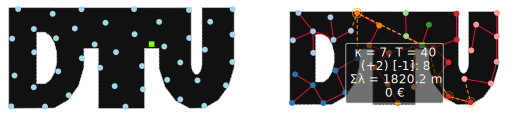

In [125]:
wfn3 = WindFarmNetwork.from_pbf(filepath='data/DTU_letters.osm.pbf', cables=7)
res_optimize = wfn3.optimize()
fig, axs = plt.subplots(1, 2, facecolor='none', figsize=(9, 4))
ax1, ax2= axs.flatten()
wfn3.plot_location(ax=ax1)
wfn3.plot(ax=ax2)

### apply buffering to `wfn3`.

The defined border is non-convex and buffering may introduce unexpected changes. For visual comparison use plot_original_vs_buffered().


<Axes: >

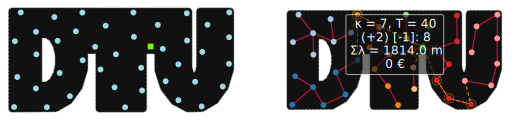

In [126]:
wfn3.buffer_border_obstacles(buffer_dist=5)
res_optimize = wfn3.optimize()
fig, axs = plt.subplots(1, 2, facecolor='none', figsize=(9, 4))
ax1, ax2= axs.flatten()
wfn3.plot_location(ax=ax1)
wfn3.plot(ax=ax2)

Original vs buffered border/obstacles can be visualized using plot_original_vs_buffered()

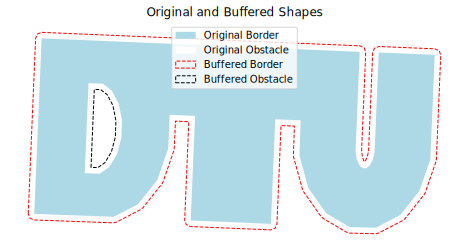

In [127]:
wfn3.plot_original_vs_buffered()

### Removal of a concavity
In this case a message is printed out, providing information about the potential changes in the border.

The defined border is non-convex and buffering may introduce unexpected changes. For visual comparison use plot_original_vs_buffered().


<Axes: >

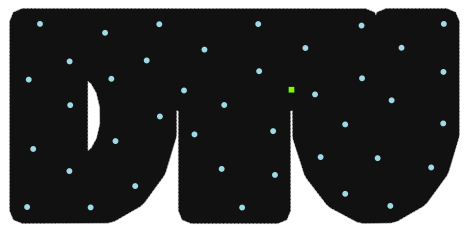

In [128]:
wfn4 = WindFarmNetwork.from_pbf(filepath='data/DTU_letters.osm.pbf', cables=7)
wfn4.buffer_border_obstacles(buffer_dist=10)
wfn4.plot_location()

Plotting original vs buffered borders confirms that one of the concavities is removed after buffering (upper left side of the border.)

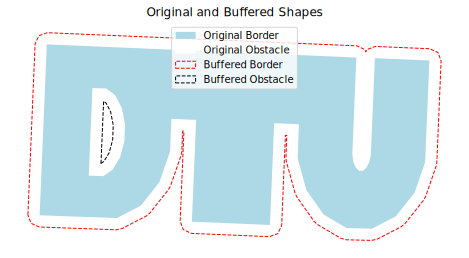

In [129]:
wfn4.plot_original_vs_buffered()

**Optimize**

The optimized network might change and use new routes after buffering

### Removal of an obstacle

In [130]:
wfn5 = WindFarmNetwork.from_pbf(filepath='data/DTU_letters.osm.pbf', cables=7)
wfn5.buffer_border_obstacles(buffer_dist=15)

The defined border is non-convex and buffering may introduce unexpected changes. For visual comparison use plot_original_vs_buffered().
Buffering by 15.00 completely removed the obstacle at index 0. For visual comparison use plot_original_vs_buffered().


Plotting original vs buffered borders confirms that abostacle (inside D letter) is removed after buffering.

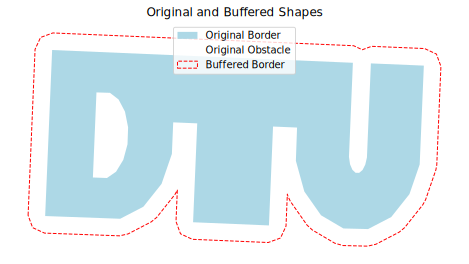

In [131]:
wfn5.plot_original_vs_buffered()

### Turbines outside the border or inside the obstacles

`OptiWindNet` provide a method `.is_layout_within_bounds` to checks if the turbinesC/substationsC are defined properly with respect to the given border and obstacles.

In [132]:
wfn6 = WindFarmNetwork.from_pbf(filepath='data/DTU_letters.osm.pbf', cables=7)
wfn6.is_layout_within_bounds()

True